In [3]:
import pandas as pd
import numpy as np
import pkg_resources
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn

In [4]:
import devanalyst
import devanalyst.simulation.GenerateTimecards as timecard
import devanalyst.simulation.tests.test_timecard as test_timecard
from devanalyst.simulation.GenerateTimecards import ModelsConfig, DefaultCostModel, GreedyAllocationModel

In [5]:
TIMECARD = None

In [6]:
def loadSampleTimecard():
    global TIMECARD
    resource_path = '/'.join(('resources', 'tests', 'simulation', 'test_releaseCycle.Entries_EXPECTED.csv'))
    resource_package = 'devanalyst'
    fullpath = pkg_resources.resource_filename(resource_package, resource_path)
        
    TIMECARD = pd.read_csv(fullpath)
    # Replace string representation of dates by actual dates
    TIMECARD['Date'] = TIMECARD['Date'].apply(lambda x: pd.Timestamp(datetime.strptime(x, '%Y-%m-%d')).date()) 
    TIMECARD.drop(['Unnamed: 0'], axis='columns', inplace=True)

    
loadSampleTimecard()

In [7]:
TIMECARD[:5]

,Sprint,Date,Team,Developer,User Story,Task Type,Time Spent
0,1,2018-01-29,Team A,Anton Easterday,UserStory #151,UNFINISHED_STORIES,2.5
1,1,2018-01-29,Team A,Anton Easterday,UserStory #97,UNFINISHED_STORIES,2.5
2,1,2018-01-29,Team A,Anton Easterday,UserStory #58,UNFINISHED_STORIES,5.0
3,1,2018-01-29,Team A,Anton Easterday,UserStory #83,UNFINISHED_STORIES,0.0
4,1,2018-01-29,Team A,Beau Hockensmith,UserStory #1,UNFINISHED_STORIES,10.0


In [8]:
SPRINT_DURATION = 10

In [9]:
def storyInfo(group_df):
    info = {}
    
    #Go back, as min['Date'] is end of first sprint
    info['Start'] = [timecard.subtractBusinessDays(group_df['Date'].min(), SPRINT_DURATION)] 
    info['End'] = [group_df['Date'].max()]
    info['Elapsed Time'] = (info['End'][0] - info['Start'][0]).days
    info['Effort'] = group_df['Time Spent'].sum()
    info['Initial Sprint'] = [group_df['Sprint'].min()]
    info['Final Sprint'] = [group_df['Sprint'].max()]  
    
    return pd.DataFrame(info)

In [10]:
def sprintInfo(group_df):
    info = {}
    
    info['Effort'] = group_df['Effort'].sum()
    info['Avg Effort'] = group_df['Effort'].mean()
    info['Stories Completed'] = [group_df['User Story'].count()]
    info['Over 1 sprint'] = [group_df[group_df['Elapsed Time']==14]['User Story'].count()]
    info['Over 2 sprint'] = [group_df[group_df['Elapsed Time']==28]['User Story'].count()]
    info['Over 3 sprint'] = [group_df[group_df['Elapsed Time']==42]['User Story'].count()]
    info['Over 4 sprint'] = [group_df[group_df['Elapsed Time']==56]['User Story'].count()]
 
    
    return pd.DataFrame(info)

In [11]:
def genBurnout(entries_df):
    bystory = entries_df.groupby('User Story')
    u = bystory.apply(storyInfo)
    u = u.reset_index()
    u.drop(['level_1'], axis='columns', inplace=True)
    s = u.groupby('Final Sprint')
    burnout = s.apply(sprintInfo)
    burnout = burnout.reset_index()
    burnout.drop(['level_1'], axis='columns', inplace=True)
    return burnout, u

In [12]:
burn1, u1 = genBurnout(TIMECARD)

In [13]:
u1[:5]

,User Story,Start,End,Elapsed Time,Effort,Initial Sprint,Final Sprint
0,UserStory #1,2018-01-15,2018-02-12,28,12.50,1,2
1,UserStory #10,2018-06-04,2018-07-16,42,11.25,11,13
2,UserStory #100,2018-02-12,2018-03-12,28,10.00,3,4
3,UserStory #101,2018-06-18,2018-07-30,42,11.25,12,14
4,UserStory #102,2018-06-18,2018-07-02,14,7.50,12,12


In [14]:
burn1

,Final Sprint,Effort,Avg Effort,Stories Completed,Over 1 sprint,Over 2 sprint,Over 3 sprint,Over 4 sprint
0,1,160.00,5.000000,32,32,0,0,0
1,2,356.25,4.567308,78,36,42,0,0
2,3,252.50,4.208333,60,21,39,0,0
3,4,308.75,5.145833,60,19,41,0,0
4,5,288.75,5.156250,56,14,40,2,0
5,6,307.50,6.275510,49,21,23,4,1
6,7,308.75,6.569149,47,12,29,6,0
7,8,218.75,6.835938,32,8,23,1,0
8,9,330.00,8.461538,39,8,19,10,2
9,10,317.50,8.581081,37,6,22,8,1


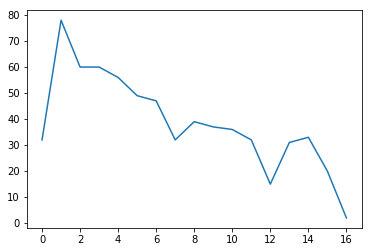

In [15]:
burn1['Stories Completed'].plot()

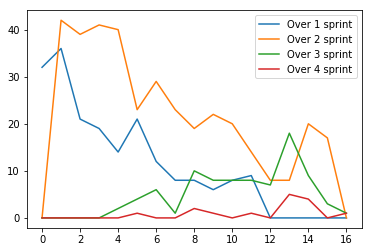

In [16]:
burn1[['Over 1 sprint', 'Over 2 sprint', 'Over 3 sprint', 'Over 4 sprint']].plot()

In [17]:
class SimpleModel:

    #
    # -slippage: a number corresponding to the percentage by which estimates differ from actuals. A 25% difference
    # corresponds to slippage of 0.25
    def __init__(self, slippage):
        self.slippage = slippage
        return
    
    # TODO - dummy implementation for now
    def runModel(self, item):
        DELAY = self.slippage   
        return 1 + DELAY

In [18]:
# Test logic
def genReleaseCycle(modelsConfig):
    timecard.RANDOM.reset(271) # Set seed so output is the same even if logic invokes random methods
    RELEASE_DURATION = 125
    SPRINT_DURATION = 10
    
    test_timecard.loadTestResources()
    
    teams_df, stories_df, teamsRepo, storiesRepo, ticketsRepo = test_timecard.initTestData(test_timecard.DEV_DF, \
                                                                                           test_timecard.PM_DF, \
                                                                                           RELEASE_DURATION, \
                                                                                           SPRINT_DURATION, \
                                                                                          modelsConfig)
    
    NUMBER_OF_SPRINTS = 25

    entries_df, worksheets = timecard.runReleaseCycle(teamsRepo, ticketsRepo, storiesRepo, datetime(2018, 1, 15), \
                                                   SPRINT_DURATION, NUMBER_OF_SPRINTS, modelsConfig)    
    
    return entries_df, worksheets

In [43]:
modelsConfig = ModelsConfig([DefaultCostModel(0.0)], [], GreedyAllocationModel(SPRINT_DURATION)) 
modelsConfig.random.reset(271)
entries_df, worksheets = genReleaseCycle(modelsConfig)

In [44]:
entries_df[:5]

,Sprint,Date,Team,Developer,User Story,Task Type,Time Spent
0,1,2018-01-29,Team A,Anton Easterday,UserStory #25,UNFINISHED_STORIES,5.0
1,1,2018-01-29,Team A,Anton Easterday,UserStory #55,UNFINISHED_STORIES,2.0
2,1,2018-01-29,Team A,Anton Easterday,UserStory #43,UNFINISHED_STORIES,1.0
3,1,2018-01-29,Team A,Anton Easterday,UserStory #124,UNFINISHED_STORIES,1.0
4,1,2018-01-29,Team A,Anton Easterday,UserStory #135,UNFINISHED_STORIES,1.0


In [45]:
burn2, u2 = genBurnout(entries_df)

In [46]:
u2[:5]

,User Story,Start,End,Elapsed Time,Effort,Initial Sprint,Final Sprint
0,UserStory #1,2018-06-04,2018-07-02,28,5.0,11,12
1,UserStory #10,2018-04-09,2018-05-07,28,9.0,7,8
2,UserStory #100,2018-05-07,2018-06-04,28,7.0,9,10
3,UserStory #101,2018-03-12,2018-03-26,14,3.0,5,5
4,UserStory #102,2018-01-15,2018-01-29,14,1.0,1,1


In [47]:
burn2

,Final Sprint,Effort,Avg Effort,Stories Completed,Over 1 sprint,Over 2 sprint,Over 3 sprint,Over 4 sprint
0,1,300.0,3.614458,83,83,0,0,0
1,2,298.0,3.870130,77,77,0,0,0
2,3,293.0,5.140351,57,55,2,0,0
3,4,298.0,4.806452,62,53,9,0,0
4,5,299.0,5.067797,59,48,11,0,0
5,6,279.0,6.340909,44,35,9,0,0
6,7,303.0,6.183673,49,30,19,0,0
7,8,285.0,6.477273,44,27,17,0,0
8,9,311.0,6.911111,45,22,23,0,0
9,10,285.0,7.500000,38,21,17,0,0


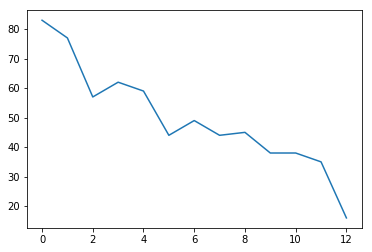

In [48]:
burn2['Stories Completed'].plot()

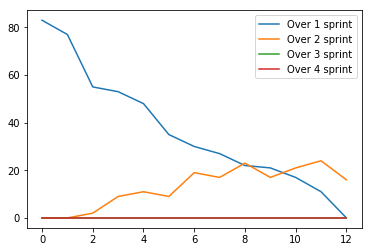

In [49]:
burn2[['Over 1 sprint', 'Over 2 sprint', 'Over 3 sprint', 'Over 4 sprint']].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x21302754278>,
 <matplotlib.legend.Legend at 0x213027e7ef0>)

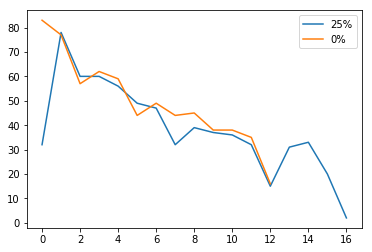

In [50]:
burn1['Stories Completed'].plot(label = '25%'), burn2['Stories Completed'].plot(label = '0%'), plt.legend()

(<matplotlib.axes._subplots.AxesSubplot at 0x213027ff7b8>,
 <matplotlib.legend.Legend at 0x21302754eb8>)

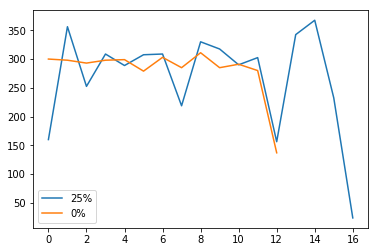

In [51]:
burn1['Effort'].plot(label = '25%'), burn2['Effort'].plot(label = '0%'), plt.legend()

(<matplotlib.axes._subplots.AxesSubplot at 0x2130296d4a8>,
 <matplotlib.legend.Legend at 0x2130297bbe0>)

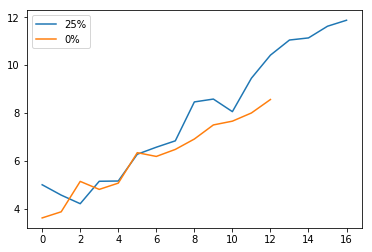

In [52]:
burn1['Avg Effort'].plot(label = '25%'), burn2['Avg Effort'].plot(label = '0%'), plt.legend()

In [53]:
worksheets[:5]

,Sprint,Team,Work Sheet,Unplanned Backlog
0,1,Team A,<devanalyst.simulation.GenerateTimecards.WorkA...,[<devanalyst.simulation.GenerateTimecards.User...
1,1,Team B,<devanalyst.simulation.GenerateTimecards.WorkA...,[<devanalyst.simulation.GenerateTimecards.User...
2,1,Team C,<devanalyst.simulation.GenerateTimecards.WorkA...,[<devanalyst.simulation.GenerateTimecards.User...
3,1,Team D,<devanalyst.simulation.GenerateTimecards.WorkA...,[<devanalyst.simulation.GenerateTimecards.User...
4,2,Team A,<devanalyst.simulation.GenerateTimecards.WorkA...,[<devanalyst.simulation.GenerateTimecards.User...


In [54]:
sheet = worksheets['Work Sheet'][0]

In [55]:
sheet.committedTime(10)

,Developer,Rejects (days),Rejects (#),Debugging (days),Debugging (#),Implementation (days),Implementation (#),Bandwidth,NEXT SPRINT (days),NEXT SPRINT (#),NEXT SPRINT Bandwidth
0,Anton Easterday,0.0,0,0.0,0,0.0,5,10.0,0.0,0,20.0
1,Beau Hockensmith,0.0,0,0.0,0,0.0,1,10.0,0.0,0,20.0
2,Bruno Studley,0.0,0,0.0,0,0.0,2,10.0,0.0,0,20.0
3,Craig Garlitz,0.0,0,0.0,0,0.0,4,10.0,0.0,0,20.0
4,Francisco Hoppe,0.0,0,0.0,0,0.0,3,10.0,0.0,0,20.0
5,Glenna Mcghie,0.0,0,0.0,0,0.0,3,10.0,0.0,0,20.0
6,Gregorio Darr,0.0,0,0.0,0,0.0,1,10.0,0.0,0,20.0
7,Heriberto Martini,0.0,0,0.0,0,0.0,3,10.0,0.0,0,20.0
8,OWNER_TBD,0.0,0,0.0,0,899.0,155,NaN,0.0,0,0.0


In [56]:
sheet.committedTasks()

,Owner,Task Type,User Story Id,Planned for Sprint,Original Estimate,Bucket,Effort Spent,Effort Remaining,Percent Achieved
0,Anton Easterday,UNFINISHED_STORIES,UserStory #25,1,5.0,CURRENT_SPRINT,5.0,0.0,1
1,Anton Easterday,UNFINISHED_STORIES,UserStory #55,1,2.0,CURRENT_SPRINT,2.0,0.0,1
2,Anton Easterday,UNFINISHED_STORIES,UserStory #43,1,1.0,CURRENT_SPRINT,1.0,0.0,1
3,Anton Easterday,UNFINISHED_STORIES,UserStory #124,1,1.0,CURRENT_SPRINT,1.0,0.0,1
4,Anton Easterday,UNFINISHED_STORIES,UserStory #135,1,1.0,CURRENT_SPRINT,1.0,0.0,1
5,Beau Hockensmith,UNFINISHED_STORIES,UserStory #144,1,10.0,CURRENT_SPRINT,10.0,0.0,1
6,Bruno Studley,UNFINISHED_STORIES,UserStory #38,1,9.0,CURRENT_SPRINT,9.0,0.0,1
7,Bruno Studley,UNFINISHED_STORIES,UserStory #60,1,1.0,CURRENT_SPRINT,1.0,0.0,1
8,Craig Garlitz,UNFINISHED_STORIES,UserStory #22,1,3.0,CURRENT_SPRINT,3.0,0.0,1
9,Craig Garlitz,UNFINISHED_STORIES,UserStory #138,1,5.0,CURRENT_SPRINT,5.0,0.0,1


In [57]:
worksheets['Work Sheet'][3].committedTasks()

,Owner,Task Type,User Story Id,Planned for Sprint,Original Estimate,Bucket,Effort Spent,Effort Remaining,Percent Achieved
0,Mohammad Tineo,UNFINISHED_STORIES,UserStory #558,1,7.0,CURRENT_SPRINT,7.0,0.0,1
1,Mohammad Tineo,UNFINISHED_STORIES,UserStory #486,1,3.0,CURRENT_SPRINT,3.0,0.0,1
2,Nohemi Santini,UNFINISHED_STORIES,UserStory #563,1,6.0,CURRENT_SPRINT,6.0,0.0,1
3,Nohemi Santini,UNFINISHED_STORIES,UserStory #477,1,3.0,CURRENT_SPRINT,3.0,0.0,1
4,Nohemi Santini,UNFINISHED_STORIES,UserStory #599,1,1.0,CURRENT_SPRINT,1.0,0.0,1
5,Olevia Haymaker,UNFINISHED_STORIES,UserStory #497,1,5.0,CURRENT_SPRINT,5.0,0.0,1
6,Olevia Haymaker,UNFINISHED_STORIES,UserStory #521,1,3.0,CURRENT_SPRINT,3.0,0.0,1
7,Olevia Haymaker,UNFINISHED_STORIES,UserStory #517,1,1.0,CURRENT_SPRINT,1.0,0.0,1
8,Olevia Haymaker,UNFINISHED_STORIES,UserStory #571,1,1.0,CURRENT_SPRINT,1.0,0.0,1
9,Pedro Sisk,UNFINISHED_STORIES,UserStory #470,1,9.0,CURRENT_SPRINT,9.0,0.0,1


In [58]:
u2[u2['Elapsed Time']==42].count()

User Story        0
Start             0
End               0
Elapsed Time      0
Effort            0
Initial Sprint    0
Final Sprint      0
dtype: int64

In [59]:
burn1.equals(burn2)

False

In [60]:
u1.equals(u2)

False

In [61]:
entries_df.equals(TIMECARD)

False